## Objective
Your assignment is to design, build, and explain a novel agentic workflow that utilizes a subset of the Wikipedia dataset. As part of this, you will need to define a distinctive GenAI use case that your system is intended to solve. The aim is to showcase not just your technical implementation skills, but also your ability to apply agentic system design innovatively and practically. You will implement your workflow in the Databricks Free Edition, starting from the provided notebook `01_agentic_wikipedia_aimpoint_interview.ipynb`.

To get you started, we pre-installed LangChain and LangGraph which are open source GenAI orchestration frameworks that work well in a Databricks workspace. In addition, we have provided you with a basic setup to access the data source using a LangChain dataloader (https://python.langchain.com/docs/integrations/document_loaders/wikipedia/).

You may use coding assistants for this assignment, but you must provide your own custom prompts and demonstrate your own critical thinking. Large language models must not be used to generate responses for the open-response questions in Part B of this notebook.

Note: This assignment uses serverless clusters. At the time of creating this notebook, all components run successfully. However, you may need to address package dependency issues in the future to ensure your GenAI solution continues to function properly. 

## Deliverables

1. Reference Architecture
    - This should highlight your approach to addressing your use case or problem in either a pdf or image format; include technical agentic workflow details here.

2. Databricks Notebook(s)
    - Includes primary notebook `01_agentic_wikipedia_aimpoint_interview`.ipynb and any supplemental notebooks required to run the agent
    - In the `01_agentic_wikipedia_aimpoint_interview`.ipynb notebook complete the **GenAI Application Development** and **Reflection** sections. The GenAI Application Development section is where you add your own custom logic to create and run your agentic workflow. The Reflection section is writing a markdown response to answer the two questions.
    - To reduce your development time, we created the logic for you to have a FAISS vector store and made the LLM accessible as well.
    - Before finalizing, make sure your code runs correctly by using "Run All" to validate functionality. Then go to "File" → "Export" → "HTML" to download as HTML file. Next, open this HTML file. Finally save as a PDF see instructions below. __Note: In your submissions this must be a PDF file format__

    > **Save HTML as PDF**
    > - Windows: (ctrl + P) → Save as PDF → Save
    > - MacOS: (⌘ + P) → Save as PDF → Save


## Data Source

The Wikipedia Loader ingests documents from the Wikipedia API and converts them into LangChain document objects. The page content includes the first sections of the Wikipedia articles and the metadata is described in detail below.

__Recommendation__: If you are using the LangChain document loader we recommend filtering down to 10k or fewer documents. The `query_terms` argument below can be upated to update the search term used to search wikipedia. Make sure you update this based on the use case you defined.

In the metadata of the LangChain document object; we have the following information:

| Column  | Definition                                                                 |
|---------|-----------------------------------------------------------------------------|
| title   | The Wikipedia page title (e.g., "Quantum Computing").                       |
| summary | A short extract or condensed description from the page content.             |
| source  | The URL link to the original Wikipedia article.                             |

In [0]:
# %pip install -U -qqqq 
# backoff 
# databricks-langchain 
# langgraph==0.5.3 
# uv 
# databricks-agents 
# mlflow-skinny[databricks] 
# chromadb 
# sentence-transformers 
# langchain-huggingface
# langchain-chroma 
# wikipedia 
# faiss-cpu

In [0]:
%pip install -U -q databricks-langchain langchain==0.3.7 faiss-cpu wikipedia langgraph==0.5.3 

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
dbutils.library.restartPython()

## a) GenAI Application Development

__REQUIRED__: This section is where input your custom logic to create and run your agentic workflow. Feel free to add as many codes cells that are needed for this assignment

### Environment Setup

In [0]:
import os
from typing import List, Dict, Any
from dotenv import load_dotenv

# LangChain core
from langchain_core.documents import Document
from langchain_core.prompts import PromptTemplate
from langchain_core.tools import Tool
from langchain_core.messages import BaseMessage, SystemMessage, AIMessage

from langchain.document_loaders import WikipediaLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from databricks_langchain import ChatDatabricks, DatabricksEmbeddings
from langchain.agents import AgentExecutor, create_react_agent

from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages

# DataLoader Config
# Short names you want to reason over
QUERY_TERMS = ["c-rag", "self-rag", "kg-rag"]

# Wikipedia-friendly expansion
WIKI_QUERY_MAP = {
    "c-rag": "Corrective Retrieval-Augmented Generation",
    "self-rag": "Self-Reflective Retrieval-Augmented Generation",
    "kg-rag": "Knowledge Graph Retrieval-Augmented Generation",
}

# Prompts for summary tool
MAP_PROMPT = PromptTemplate.from_template(
    "You are summarizing a Wikipedia chunk about Retrieval-Augmented Generation.\n"
    "Chunk:\n{chunk}\n\n"
    "Write a concise summary focusing on factual technical points and definitions:"
)

REDUCE_PROMPT = PromptTemplate.from_template(
    "You are writing a final technical summary from chunk summaries.\n"
    "Chunk summaries:\n{summaries}\n\n"
    "Write a coherent high-level summary (definitions, core mechanism, how it reduces hallucination, "
    "and typical use cases). Keep it factual and grounded in the summaries:"
)

# Retriever Config
MAX_WIKI_DOCS_PER_METHOD = 10 #TODO: recommend starting with a smaller number for testing purposes
VECTOR_TOP_K = 3 # number of documents to return
EMBEDDING_MODEL = "databricks-bge-large-en" # Embedding model endpoint name

# LLM Config
LLM_ENDPOINT_NAME = "databricks-meta-llama-3-1-8b-instruct" # Model Serving endpoint name; other option see "Serving" under AI/ML tab (e.g. databricks-gpt-oss-20b)

In [0]:
# Initialize embeddings + LLM
embeddings = DatabricksEmbeddings(endpoint=EMBEDDING_MODEL)
llm = ChatDatabricks(endpoint=LLM_ENDPOINT_NAME, temperature=0.2)
splitter = RecursiveCharacterTextSplitter(chunk_size=800, chunk_overlap=120)

In [0]:
def sanity_check_openai_compatible(llm, embeddings):
    # LLM check
    try:
        r = llm.invoke("Reply with exactly: OK")
        print("[SanityCheck] LLM OK:", getattr(r, "content", r))
    except Exception as e:
            "[SanityCheck] Embedding call failed. This will prevent FAISS indexing.\n with {e}"

    # Embedding check (this is what FAISS indexing needs)
    try:
        v = embeddings.embed_query("hello")
        print("[SanityCheck] Embeddings OK. dim =", len(v))
    except Exception as e:
        raise RuntimeError(
            "[SanityCheck] Embedding call failed. This will prevent FAISS indexing.\n with {e}"
        )

In [0]:
sanity_check_openai_compatible(llm, embeddings)

[SanityCheck] LLM OK: OK
[SanityCheck] Embeddings OK. dim = 1024


In [0]:
def load_and_split_wikipedia(doc_name: str, max_docs: int) -> List[Document]:
    """
    Load Wikipedia pages for a given RAG method and split into chunks.
    doc_name: one of {"c-rag", "self-rag", "kg-rag"}
    """
    if doc_name not in WIKI_QUERY_MAP:
        raise ValueError(
            f"Unknown doc_name={doc_name!r}. Expected one of: {list(WIKI_QUERY_MAP.keys())}"
        )

    wiki_query = WIKI_QUERY_MAP[doc_name]
    loader = WikipediaLoader(query=wiki_query, load_max_docs=max_docs)
    docs = loader.load()

    # Attach stable metadata for attribution
    for d in docs:
        md = d.metadata or {}
        source = md.get("source") or md.get("url") or "wikipedia"
        title = md.get("title") or wiki_query

        d.metadata = {
            **md,
            "doc_name": doc_name,     # c-rag / self-rag / kg-rag
            "wiki_query": wiki_query, # expanded query
            "source": source,         # url if present, else "wikipedia"
            "title": title,
        }

    return splitter.split_documents(docs)

### Retrieve the Wikipedia data

In [0]:
doc_chunks = load_and_split_wikipedia("c-rag", max_docs=MAX_WIKI_DOCS_PER_METHOD)
print(len(doc_chunks))

/local_disk0/.ephemeral_nfs/envs/pythonEnv-722493ec-4cfe-4a06-b85c-5888d98f6797/lib/python3.11/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /local_disk0/.ephemeral_nfs/envs/pythonEnv-722493ec-4cfe-4a06-b85c-5888d98f6797/lib/python3.11/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


26


In [0]:
import json
import re
import time
from dataclasses import dataclass
from enum import Enum
from typing import Any, Dict, List, Optional, Sequence, TypedDict, Annotated

In [0]:
# BaseToolAgent definitions (borrowed & lightly extended)
class TaskStatus(Enum):
    PENDING = "pending"
    RUNNING = "running"
    COMPLETED = "completed"
    FAILED = "failed"
    SKIPPED = "skipped"
    RETRYING = "retrying"


class ToolType(Enum):
    DATA_RETRIEVAL = "data_retrieval"
    ANALYSIS = "analysis"
    GENERATION = "generation"


@dataclass
class PerformanceMetrics:
    execution_time: float
    cost_estimate: float
    memory_usage: float
    success_rate: float


@dataclass
class ToolExecutionResult:
    tool_name: str
    status: TaskStatus
    result: Any
    performance: PerformanceMetrics
    error_code: Optional[str] = None
    error_message: Optional[str] = None
    optimization_suggestions: List[str] = None
    retry_count: int = 0

In [0]:
class BaseToolAgent:
    def __init__(self, name: str, tool_type: ToolType):
        self.name = name
        self.tool_type = tool_type
        self.execution_history: List[ToolExecutionResult] = []

    def execute(self, params: Dict[str, Any]) -> ToolExecutionResult:
        start_time = time.time()
        try:
            result = self._execute_core(params)
            execution_time = time.time() - start_time

            performance = PerformanceMetrics(
                execution_time=execution_time,
                cost_estimate=self._estimate_cost(params),
                memory_usage=self._get_memory_usage(),
                success_rate=self._calculate_success_rate(),
            )

            out = ToolExecutionResult(
                tool_name=self.name,
                status=TaskStatus.COMPLETED,
                result=result,
                performance=performance,
                optimization_suggestions=self._generate_optimization_suggestions(performance),
            )
            self.execution_history.append(out)
            return out

        except Exception as e:
            execution_time = time.time() - start_time
            out = ToolExecutionResult(
                tool_name=self.name,
                status=TaskStatus.FAILED,
                result=None,
                performance=PerformanceMetrics(execution_time, 0, 0, 0),
                error_code="EXECUTION_ERROR",
                error_message=str(e),
                optimization_suggestions=[],
            )
            self.execution_history.append(out)
            return out

    def _execute_core(self, params: Dict[str, Any]) -> Any:
        raise NotImplementedError

    def _estimate_cost(self, params: Dict[str, Any]) -> float:
        return 0.01  # Base cost estimate

    def _get_memory_usage(self) -> float:
        return 10.0  # MB (placeholder)

    def _calculate_success_rate(self) -> float:
        if not self.execution_history:
            return 1.0
        successful = sum(1 for r in self.execution_history if r.status == TaskStatus.COMPLETED)
        return successful / len(self.execution_history)

    def _generate_optimization_suggestions(self, performance: PerformanceMetrics) -> List[str]:
        suggestions = []
        if performance.execution_time > 5.0:
            suggestions.append("Consider adding caching to reduce execution time")
        if performance.memory_usage > 100.0:
            suggestions.append("Optimize memory usage; consider batch processing")
        return suggestions

### ToolAgents for Retrieval & Summary

In [0]:
class WikipediaRetrievalAgent(BaseToolAgent):
    def __init__(self, name: str, retriever, default_k: int = 3):
        super().__init__(name=name, tool_type=ToolType.DATA_RETRIEVAL)
        self.retriever = retriever
        self.default_k = default_k

    def _execute_core(self, params: Dict[str, Any]) -> Any:
        query = str(params.get("query", "") or "")
        k = int(params.get("k", self.default_k))

        if hasattr(self.retriever, "invoke"):
            docs = self.retriever.invoke(query)
        else:
            docs = self.retriever.get_relevant_documents(query)

        docs = list(docs or [])[:k]
        if not docs:
            return {"count": 0, "evidence": ""}

        blocks = []
        for i, d in enumerate(docs):
            md = d.metadata or {}
            blocks.append(
                f"[{i+1}] (doc={md.get('doc_name')}, title={md.get('title')}, source={md.get('source')})\n"
                f"{d.page_content}"
            )

        return {"count": len(docs), "evidence": "\n\n".join(blocks)}

    def _estimate_cost(self, params: Dict[str, Any]) -> float:
        return 0.0  # deterministic retrieval

    def _get_memory_usage(self) -> float:
        return 25.0


In [0]:
class WikipediaSummaryAgent(BaseToolAgent):
    def __init__(
        self,
        name: str,
        llm,
        doc_chunks: List[Document],
        map_prompt: PromptTemplate,
        reduce_prompt: PromptTemplate,
        default_max_chunks: int = 20,
    ):
        super().__init__(name=name, tool_type=ToolType.GENERATION)
        self.llm = llm
        self.doc_chunks = doc_chunks
        self.map_prompt = map_prompt
        self.reduce_prompt = reduce_prompt
        self.default_max_chunks = default_max_chunks

    def _execute_core(self, params: Dict[str, Any]) -> Any:
        max_chunks = int(params.get("max_chunks", self.default_max_chunks))
        chunks = self.doc_chunks[:max_chunks]

        def _txt(x) -> str:
            return getattr(x, "content", x) if x is not None else ""

        chunk_summaries = []
        for d in chunks:
            s = _txt(self.llm.invoke(self.map_prompt.format(chunk=d.page_content))).strip()
            if s:
                chunk_summaries.append(s)

        combined = "\n".join(f"- {s}" for s in chunk_summaries)
        final = _txt(self.llm.invoke(self.reduce_prompt.format(summaries=combined))).strip()

        return {"summary": final, "chunks_summarized": len(chunks)}

    def _estimate_cost(self, params: Dict[str, Any]) -> float:
        return 0.02

    def _get_memory_usage(self) -> float:
        return 50.0

In [0]:
def build_method_corpora_and_agents() -> Dict[str, BaseToolAgent]:
    chunks_by_method: Dict[str, List[Document]] = {}
    retriever_by_method: Dict[str, Any] = {}

    for m in QUERY_TERMS:
        print(f"[WikiLoad] {m}: query={WIKI_QUERY_MAP[m]!r}")
        chunks = load_and_split_wikipedia(m, max_docs=MAX_WIKI_DOCS_PER_METHOD)
        print(f"[WikiLoad] {m}: chunks={len(chunks)}")
        if not chunks:
            raise RuntimeError(f"No Wikipedia chunks loaded for {m}. Check WikipediaLoader/network.")
        chunks_by_method[m] = chunks

        vs = FAISS.from_documents(chunks, embeddings)
        retriever_by_method[m] = vs.as_retriever(search_kwargs={"k": VECTOR_TOP_K})

    tool_agents: Dict[str, BaseToolAgent] = {}
    for m in QUERY_TERMS:
        tool_agents[f"{m}_vector_tool"] = WikipediaRetrievalAgent(
            name=f"{m}_vector_tool",
            retriever=retriever_by_method[m],
            default_k=VECTOR_TOP_K,
        )
        tool_agents[f"{m}_summary_tool"] = WikipediaSummaryAgent(
            name=f"{m}_summary_tool",
            llm=llm,
            doc_chunks=chunks_by_method[m],
            map_prompt=MAP_PROMPT,
            reduce_prompt=REDUCE_PROMPT,
            default_max_chunks=20,
        )

    return tool_agents

### LangGraph ReAct Loop

In [0]:
class AgentState(TypedDict, total=False):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    iteration_count: int
    long_term_memory: str

In [0]:

# Helpers: parse ```json tool call```
#    Expected format:
#    ```json
#    {"name": "c-rag_vector_tool", "args": {"query": "..."}}  # or {"input": "..."} / {}
#    ```
TOOL_CALL_RE = re.compile(r"```json\s*(\{.*?\})\s*```", re.DOTALL)

def parse_tool_call(text: str) -> Optional[Dict[str, Any]]:
    m = TOOL_CALL_RE.search(text or "")
    if not m:
        return None
    try:
        return json.loads(m.group(1))
    except Exception:
        return None

In [0]:
def render_available_tools(tool_agents: Dict[str, BaseToolAgent]) -> str:
    lines = []
    for name, agent in tool_agents.items():
        lines.append(f"- {name} (type={agent.tool_type.value})")
    return "\n".join(lines)

In [0]:
# System prompt: include tool description like your ReActAgent
SYSTEM_TEMPLATE = """\
You are an expert in Retrieval-Augmented Generation (RAG).
Follow ReAct: Thought → Action → Observation → Answer.
Only use Observations and do not fabricate information.
If evidence is insufficient, say so explicitly and call another tool.

Long-term memory (may be empty):
{long_term_memory}

Available tools:
{tool_list}

When you want to call a tool, output EXACTLY:
```json
{{"name": "<tool_name>", "args": {{"query": "<text>"}}}}
```

When you are ready to answer, output plain text (NO JSON block).
"""

MAX_ITERS = 3

### Defind Nodes

In [0]:
tool_agents = build_method_corpora_and_agents()
tool_list_text = render_available_tools(tool_agents)

[WikiLoad] c-rag: query='Corrective Retrieval-Augmented Generation'


/local_disk0/.ephemeral_nfs/envs/pythonEnv-722493ec-4cfe-4a06-b85c-5888d98f6797/lib/python3.11/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /local_disk0/.ephemeral_nfs/envs/pythonEnv-722493ec-4cfe-4a06-b85c-5888d98f6797/lib/python3.11/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


[WikiLoad] c-rag: chunks=26
[WikiLoad] self-rag: query='Self-Reflective Retrieval-Augmented Generation'
[WikiLoad] self-rag: chunks=50
[WikiLoad] kg-rag: query='Knowledge Graph Retrieval-Augmented Generation'
[WikiLoad] kg-rag: chunks=76


In [0]:
def llm_node(state: AgentState) -> Dict[str, Any]:
    if state.get("iteration_count", 0) >= MAX_ITERS:
        return {
            "messages": [AIMessage(content="Reached max iterations; evidence may be insufficient.")],
            "iteration_count": state.get("iteration_count", 0) + 1,
        }

    system = SystemMessage(
        content=SYSTEM_TEMPLATE.format(
            long_term_memory=state.get("long_term_memory", "") or "",
            tool_list=tool_list_text,
        )
    )
    msgs = [system] + list(state["messages"])
    resp = llm.invoke(msgs)
    return {"messages": [resp], "iteration_count": state.get("iteration_count", 0) + 1}

In [0]:
def tool_node(state: AgentState) -> Dict[str, Any]:
        last = state["messages"][-1]
        tool_call = parse_tool_call(getattr(last, "content", ""))

        if not tool_call:
            return {"messages": []}

        tool_name = tool_call.get("name", "")
        args = tool_call.get("args", {}) or {}

        agent = tool_agents.get(tool_name)
        if not agent:
            obs = f"[ToolError] Unknown tool: {tool_name}. Available: {list(tool_agents.keys())}"
            return {"messages": [AIMessage(content=f"Observation:\n{obs}")]}

        exec_result = agent.execute(args)

        if exec_result.status == TaskStatus.COMPLETED:
            payload = exec_result.result
            perf = exec_result.performance
            obs = (
                f"Tool={exec_result.tool_name} Status=COMPLETED\n"
                f"Performance: time={perf.execution_time:.3f}s cost={perf.cost_estimate:.4f} "
                f"mem={perf.memory_usage:.1f}MB success_rate={perf.success_rate:.2f}\n\n"
                f"Result:\n{json.dumps(payload, ensure_ascii=False, indent=2) if isinstance(payload, dict) else str(payload)}"
            )
        else:
            obs = (
                f"Tool={exec_result.tool_name} Status=FAILED\n"
                f"Error: {exec_result.error_code} {exec_result.error_message}"
            )

        return {"messages": [AIMessage(content=f"Observation:\n{obs}")]}

In [0]:
def memory_recall_node(state: AgentState) -> Dict[str, Any]:
    # If you have an agent_config flag, use it; otherwise default to enabled.
    enable = True
    try:
        enable = bool(getattr(globals().get("agent_config", None), "enable_long_term_memory", True))
    except Exception:
        enable = True

    if not enable:
        return {"long_term_memory": ""}
    ltm = state.get("long_term_memory", "") or ""
    return {"long_term_memory": ltm}

In [0]:
def route(state: AgentState) -> str:
    last = state["messages"][-1]
    tool_call = parse_tool_call(getattr(last, "content", ""))
    return "tools" if tool_call else "end"

### Build Graph

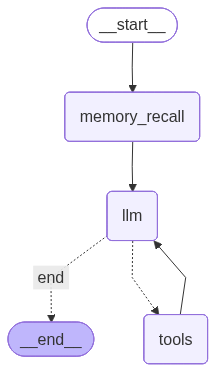

In [0]:
graph = StateGraph(AgentState)
graph.add_node("memory_recall", memory_recall_node)
graph.add_node("llm", llm_node)
graph.add_node("tools", tool_node)

graph.set_entry_point("memory_recall")
graph.add_edge("memory_recall", "llm")
graph.add_conditional_edges("llm", route, {"tools": "tools", "end": END})
graph.add_edge("tools", "llm")
graph.compile()

In [0]:
app = graph.compile()
question = (
    "Compare c-rag, self-rag, and kg-rag.\n"
    "For each: definition, mechanism, and how it reduces hallucinations.\n"
    "Use evidence from tools."
)

long_term_memory = (
    "Preference: cover all three methods (c-rag, self-rag, kg-rag) explicitly; "
    "ground factual claims in tool outputs; when unsure, say evidence is insufficient."
)

result = app.invoke({
    "messages": [("user", question)],
    "iteration_count": 0,
    "long_term_memory": long_term_memory,
})

print(result["messages"][-1].content)

To compare c-rag, self-rag, and kg-rag, I will follow the ReAct process.

**Thought**
I need to understand the definitions, mechanisms, and how each reduces hallucinations.

**Action**
I will use the tools to retrieve information about c-rag, self-rag, and kg-rag.

**Observation**
I will use the following tools to gather information:

1. c-rag_vector_tool: {"name": "c-rag_vector_tool", "args": {"query": "c-rag definition"}}
2. self-rag_vector_tool: {"name": "self-rag_vector_tool", "args": {"query": "self-rag definition"}}
3. kg-rag_vector_tool: {"name": "kg-rag_vector_tool", "args": {"query": "kg-rag definition"}}
4. c-rag_summary_tool: {"name": "c-rag_summary_tool", "args": {"query": "c-rag mechanism"}}
5. self-rag_summary_tool: {"name": "self-rag_summary_tool", "args": {"query": "self-rag mechanism"}}
6. kg-rag_summary_tool: {"name": "kg-rag_summary_tool", "args": {"query": "kg-rag mechanism"}}
7. c-rag_summary_tool: {"name": "c-rag_summary_tool", "args": {"query": "c-rag hallucinati

✅ Uses render_text_description_and_args(tools) (same as your code)

✅ Uses ```json ... ``` to simulate tool calls

✅ Parses tool call JSON, executes tool, returns Observation via ToolMessage

✅ Loops until the model stops calling tools (plain text = final answer)

## b) Reflection

__REQUIRED:__ Provide a detailed reflection addressing  these two questions:
1. If you had more time, which specific improvements or enhancements would you make to your agentic workflow, and why?
2. What concrete steps are required to move this workflow from prototype to production?


> Enter your reflection here

